# Introduction to OpenAI Gym

One of the challenges of RL is that in order to train an agent you first need to have a working environment. OpenAI gym is a toolkit that provides a wide variety of simulated environments so you can train agents, compare them, or develop new RL algorithms.

In [1]:
#Installing OpenAI Gym
#import sys
#!{sys.executable} -m pip install --upgrade gym

    100% |████████████████████████████████| 1.5MB 2.5MB/s ta 0:00:011
    100% |████████████████████████████████| 1.0MB 1.6MB/s ta 0:00:011
    100% |████████████████████████████████| 829kB 1.4MB/s ta 0:00:011
  Running setup.py bdist_wheel for gym ... done
  Stored in directory: /Users/siddharth/Library/Caches/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /Users/siddharth/Library/Caches/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built gym future


In [1]:
import gym

Now create the first environment:

In [2]:
env = gym.make("CartPole-v0")
obs = env.reset()
obs
env.render()

array([-0.04303083,  0.04961465,  0.00299637, -0.02529808])

The make() function creates an environment, in this case a CartPole environment. This is a 2D simulation in which a cart can be accelerated left or right in order to balance a pole placed on top of it.

After the environment is created, we must initialize the reset() method. this returns the first observation. Observation depends on the type of environment. For the CartPole environment, each observation is a 1D NumPy array containing four floats: these floats represent the cart's horizontal position (0.0 = center), its velocity, the angle of the pole (0.0 = vertical) and its angular velocity. 

Finally, the render() method displays the environment.

If you want the render() to return the rendered image as a NumPy array, you can set the mode parameter to rgb_array(note that other environments may support different modes):

In [3]:
img = env.render(mode = "rgb_array")
img.shape #height, width, channels (3 = RGB)

(400, 600, 3)

Let,s ask the environment which actions are possible:

In [4]:
env.action_space

Discrete(2)

Discrete(2) means that the possible actions are integers 0 and 1, which represent accelerating left(0) and right (1). Other environments may have more discrete kinds of actions. 

Since pole is leaning towards the right, lets accelerate it towards the right:

In [5]:
action = 1 #accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.04203854,  0.2446935 ,  0.00249041, -0.31703411])

In [6]:
reward

1.0

In [7]:
done

False

In [8]:
info

{}

The step() method executes the given action and returns four values:

*obs*

This is the new observation. The cart is now moving towards the right (obs[1] > 0). The pole is still tilted towards the right (obs[2]>0), but its angular velocity is now negative (obs[3]<0), so it will likely be tilted towards the left after the next step.

*reward*

In this environment, you get a reward of 1.0 at every step, no matter what you do, so the goal is to keep running as long as possible.

*done*

This value will be True when the episode is over. This will happen when the pole tilts too much. After that, the environment must be reset before it can be used again.

*info*

This dictionary may provide extra debug information in other environments. This data should NOT be used be for training (it would be cheating).

Let's hardcode a simple policy that accelerates left when pole is leaning toward the left and accelerates right when pole is leaning towards the right. We will run this policy to see the average rewards it gets over 500 episodes


In [9]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle <0 else 1

totals = []

for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000): #1000 steps max
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [10]:
import numpy as np

In [11]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.738, 8.475928031785074, 24.0, 71.0)

Even with 500 tries, this policy never managed to keep the pole upright for more than 68 consecutive steps. Let's see if neural network can come up with a better policy.

## Neural Network Policies

The neural network will take an observation as input, and it will build a probability for each output action. It will then select an action randomly according to these estimated probabilities.

The reason we pick action randomly from the estimated probabilities instead of the action WITH *highest* probability is because we want to **explore** the action space rather than just exploit it. 

In [12]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [13]:
#1. Specify the neural network architecture

n_inputs = 4 # == env.observation_space.shape[0]
n_hidden = 4 #simple task, dont need more hidden neurons
n_outputs = 1 #only 1 outputs the probability of accelerating left
initializer = tf.contrib.layers.variance_scaling_initializer()

In [14]:
#2. Build the neural network
X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden = fully_connected(X, n_hidden, activation_fn = tf.nn.elu,
                        weights_initializer = initializer)
logits = fully_connected(hidden, n_outputs, activation_fn = None,
                        weights_initializer = initializer)
outputs = tf.nn.sigmoid(logits)

In [28]:
#3. Select a random action based on the estimated probabilities
#no axis input exists in tf.concat. It's concat_dim now.
p_left_and_right = tf.concat(concat_dim = 1, values = [outputs, 
                                                1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples = 1)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In this cdoe:
- After the imports, we define a neural network architecture.


- Next we build the neural network. In this example, its a vanilla Multi-Layer Perceptron with a single output. Note that the output layer uses the logistic(sigmoid) activation function in order to output a probability from 0.0 to 1.0. If there were more outputs then we would use softmax activation instead.


- Lastly, we call the multinomial() function to pick a random action. The function independently samples one(or more) integers, given the log probability of each integer, For example, if you call it with the array [np.log(0.5), np.log(0.2), np.log(0.3)] and with num_samples = 5, then it will output five integers, each of which will have a 50% probability of being 0, 20% of being 1 and 30% of being 2. 


- In our case we just need one integer representing the action to take. Since the outputs tensor only contains the probability of going left, we must first concatenate 1-outputs to it to have tensor containing the probability of both left and right actions. Note that if there were more than two possible actions, the neural network would have to output one probability per action so you would not need a concatenation step.

## Evaluating Actions: The Credit Assignment Problem

Since there are many actions that can be taken before seeing an agent fail, it becomes difficult to determine which particular action/s were responsible for this failure. In these situations we apply a discounted weight (0.95) on each action taken from the present day to the past to put a weight on each of the actions taken. The rewards of which are normalized (subract mean, divide by std deviation) and the positive scoring results are considered.

## Policy Gradients

Creating gradients for an agent in a system over multiple trials. The positive gradients are reinforced by moving in the direction of those gradients and the negative gradients are reinforced by moving away from the direction of these gradients. The magnitude of movement depends on the reward scores of each action.

The implementation is as follows. 

We will train the neural network policy we built earlier so that it learns to balance the pole on the cart. Let's start by completing the construction phase we coded earlier to add the target probability, cost function, and the training operation. Since we are acting as though the chosen action is the best possible action, the target probability must be 1.0 if chosen action is action 0(left) and 0.0 if it is action 1(right):

In [19]:
y = 1. - tf.to_float(action)

#Now we have target probability. We will use cross entropy to compute 
#gradients

learning_rate = 0.01

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
    targets = y, logits = logits)

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)

**Note that we are calling the optimizer's compute_gradients() method instead of the minimize() method. This is because we want to tweak the gradients before we apply them.**

The compute_gradients() method returns a list of gradient vector/variable pairs(one pair per trainable variable). Let's all put the gradients in a list, to make it more convenient to obtain their values:

In [30]:
gradients = [grad for grad, variable in grads_and_vars]
#print(gradients)

During the execution phase, the algorithm will run the policy and at each step it will evaluate these gradient tensors and store their values. 

After multiple iterations these gradients will be tweaked. 

Next it will need to feed the resulting gradients back to the optimizer so it can perform an optimization step.

This means we need **one placeholder per gradeint vector.** 

Moreover, we must create the operation that will apply the updated gradients. For this we call the optimizer's apply_gradients() function, which takes a list of gradient vector/variable pairs.

Instead of giving the original vectors, we will give it a list containing the updated gradients (i.e., the ones fed through gradient placeholders):

In [31]:
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape = grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
    
training_op = optimizer.apply_gradients(grads_and_vars_feed)

On to the execution phase. we will ned a couple of functions to compute the total discounted rewards given the raw rewards and to normalize result across multiple episodes.

In [32]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards*discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

In [56]:
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards) 
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    rewards_std = flat_rewards.std()
    return [(discounted_rewards - rewards_mean)/rewards_std
           for discounted_rewards in all_discounted_rewards]

Let's check that this works:

In [57]:
discount_rewards([10,0,-50], discount_rate = 0.8)

array([-22., -40., -50.])

In [ ]:
#Some error in the book here
#discount_and_normalize_rewards([[10,0,-50], [10,20]],
#                               discount_rate = 0.8)

We now have all we need to train the policy:

In [59]:
n_iterations = 250      #number of training iterations
n_max_steps = 1000      #max steps per episode
n_games_per_update = 10 #train policy every 10 episodes
save_iterations = 10    #Save the model every 10 training iterations
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iterations in range(n_iterations):
        all_rewards = [] #all sequences of raw rewards for each episode
        all_gradients = [] #gradients saved at each step of each episode
        for game in range(n_games_per_update):
            current_rewards = [] #all raw rewards from the current episode
            current_gradients = [] #all gradients from the current episode
            obs = env.reset()
            for steps in range(n_max_steps):
                action_val, gradient_val = sess.run(
                    [action, gradients],
                    feed_dict = {X: obs.reshape(1, n_inputs)}) #one obs
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        #At this point we have run the policy for 10 episodes, and we are
        #ready for a policy update using alogirthm described earlier
        
        all_rewards = discount_and_normalize_rewards(all_rewards)
        feed_dict{}
        
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            #multiply the gradients by the action scores, and compute mean
            mean_gradients = np.mean(
            [rewards*all_gradients[game_index][step][var_index]
            
            for game_index, rewards in enumerate(allrewards)
            for step, reward in enumerate(rewards)], axis = 0)
            
            feed_dict[grad_placeholder] = mean_gradients
        sess.run(training_op, feed_dict = feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

 Each training iteration starts by running the policy for 10 episodes with maximum 1000 steps per episode. At each step we also compute the gradients pretending that the chosen action was the best. 
 
 After these 10 episodes have been run, we compute the action scores using the discount_and_normalize_rewards() function;
 
 We go through each trainable variable, across all episodes and steps, to multiply each gradient vector by its corresponding action scorel and we compute the mean of the resulting gradients.
 
 Finally, we run the training operation, feeding it these mean gradients (one per trainable variable). We also save the model every 10 training oeprations
 
 
 # Markov Decision Processes
 
 Used in situation where there are multiple states and multiple actions in each step the agent moves through the system. To find the best state-action pairs we use something called the Q-values.
 
 We start by initializing all the Q-Value estimate to zero, then update them using the Q-value iteration algorithm. The optimal Q-Value of the state action pair (s,a) is the sum of discounted future rewards of the agent can expect on average after it reaches the state s and chooses action a, but before it sees the outcome of this action, assuming it behaves optimally after that. 
 
Let's apply this algorithm. First we need to define the Markov decision process (MDP):

In [61]:
nan = np.nan #represents impossible actions

T = np.array([#shape = [s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8,0.2,0.0]],
    [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0,0.0,1.0]],
    [[nan,nan,nan], [40,0.0,0.0], [nan,nan,nan]], 
])

R = np.array([ #shape = [s,a,s']
    [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    [[10., 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.]],
    [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]],
])

possible_actions = [[0,1,2], [0,2], [1]]

In [64]:
#Now, let's run the Q-value iteration algorithm:

Q = np.full((3,3), -np.inf) #-inf for all impossible actions
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0 #Initial value = 0.0 for all possible actions
    
learning_rate = 0.01
discount_rate = 0.95
n_iterations = 100

for iteration in range(n_iterations):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s,a] = np.sum([
                T[s,a,sp]*(R[s,a,sp] + discount_rate*np.max(Q_prev[sp]))
                for sp in range(3)
            ])
    

In [65]:
Q

array([[5.59419690e+39, 2.19540396e+39, 4.46126592e+39],
       [1.35247138e+40,           -inf, 3.44628523e+40],
       [          -inf, 8.78161582e+40,           -inf]])

In [66]:
np.argmax(Q, axis = 1) #optimal action for each state

array([0, 2, 1])

This gives us an optimal policy for MDP, when using a discount rate of 0.95: in state $s_0$ choose action $a_0$, in state $s_1$ choose $a_2$ (go through fire), and in state $s_2$ choose actions $a_1$ (the only possible action)

Interestingly, if you reduce discount rate to 0.9, the optimal polic changes: in state $s_1$ the best action becomes $a_0$ (stay put, dont go through fire). It makes sense because if you value present more than future, then the prospect of future rewards is not worth immediate pain.

## Temporal Difference and Q-Learning

Using the TD Learning and Q-Learning algorithms we try and take into account the fact that only the different states and actions are available to an agent. The transition probabilities and rewards are not. In such a scenario we introduce the TD Learning and Q-learning algorithm which work similarly to stochastic gradient descent and learn over time the state-reward pairs through an update mechanism. 

It can be implemented as follows:

In [67]:
import numpy.random as rnd

In [ ]:
learning_rate0 = 0.05
learning_rate_decay = 0.1
n_iterations = 20000

s = 0 #start in state 0

Q = np.full((3,3), -np.inf) #-inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0 #initial value = 0.0, for all possible actions
    
    
for iteration in range(n_iterations):
    a = rnd.choice(possible_actions[s]) #choose an action randomly
    sp = rnd.choice(range(3), p = T[s,a]) #pick next state using T[s,a]
    reward = R[s, a, sp]
    learning_rate = learning_rate0/(1+iteration * learning_rate_decay)
    Q[s, a] = learning_rate * Q[s,a] + (1 - learning_rate) * (
        reward + discount_rate * np.max(Q[sp])
    )
    
    s = sp #move to next state
        

# Learning to Play Ms. PAC-Man Using Deep Q-Learning

In [103]:
#install cmake needed to install atari evironments
#import sys
#!{sys.executable} -m pip install cmake boost boost-python sdl2 swig wget

In [102]:
#!{sys.executable} -m pip install boost-py

In [95]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape #[height, width, channel]

(210, 160, 3)

In [96]:
env.action_space

Discrete(9)

As you can see, there are nine discrete actions available which correspond to the nine possible positions of the joystick (left, right, up, down, center, upper left, and so on), and the observations are screenshots of Atari screen, represented as 3D NumPy arrays.

These images are a bit large, so we will create a small preprocessing function that will crop the image and shrink it down to 88x80 pixels, convert it to grascale, and improve the contrast of Ms.Pac-Man. This will reduce the amount f computations required by the DQN, and speed up training.

In [99]:
import matplotlib.pyplot as plt

In [105]:

mspacman_color = np.array([210,164,74]).mean()

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] #crop and downsize
    img = img.mean(axis = 2) #to greyscale
    img[img==mspacman_color] = 0 #improve contrast
    img = (img - 128)/128 - 1 #normalize from -1. to 1.
    return img.reshape(88,80,1)

img = preprocess_observation(obs)

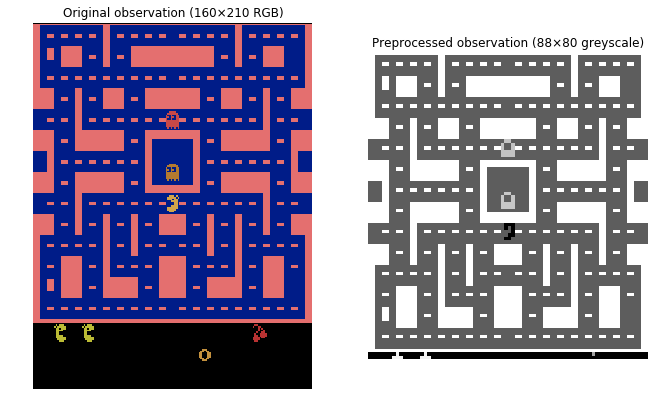

In [106]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

Next, let's create the DQN. It could just take state-action pair(s,a) as input, and output an estimate of the corresponding Q-value Q(s,a) but since the actions are discrete it is more convenient to use neural networks that takes only state s as input and outputs one Q-Value estimate per action.

The DQN will be composed of three convolutional layers, followed by two fully connected layers, including the output layer. 

As we will see, the training algorithm we will use requires two DQNs, with the same architecture (but different parameters): one will be used to drive Ms. Pac-Man during training (the actor), and the other will watch the actor and learn from its trials and errors (the critic). At regular intervals we will copy the critic to the actor.

Since we need two identical DQNs, we will create a q_network() function to build them:

In [118]:
from tensorflow.contrib.layers import convolution2d, fully_connected

In [119]:
tf.reset_default_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4,2,1]
conv_paddings = ["SAME"]*3
conv_activation = [tf.nn.relu]*3
n_hidden_in = 64*11*10 #conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n #9 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()

In [120]:
def q_network(X_state, scope):
    prev_layer = X_state
    conv_layer = []
    with tf.variable_scope(scope) as scope:
        for n_maps, kernel_size, stride, padding, activation in zip(
            conv_n_maps, conv_kernel_sizes, conv_strides,
            conv_paddings, conv_activation):
            prev_layer = convolution2d(
                prev_layer, num_outputs = n_maps, kernel_size = kernel_size,
                stride = stride, padding = padding, activation_fn = activation,
                weights_initializer = initializer)
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape = [-1, n_hidden_in])
        hidden = fully_connected(
            last_conv_layer_flat, n_hidden, activation_fn = hidden_activation,
            weights_initializer = initializer)
        outputs = fully_connected(
            hidden, n_outputs, activation_fn = None,
            weights_initializer = initializer)
    
    traininable_vars = tf.get_collection(tf.GraphKeys.TRAIANABLE_VARIABLES,
                                        scope = scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var 
                             for var in trainable_vars}
    
    return outputs, trainable_vars_by_name
        
        

The first part of the code defines the hyperparameters of the DQN architecture. The q_network() function creates the DQNm taking the envirionment's state X_State as input, and the name of the variable scope.

Note that we will just use one observation to represent the environment's state since theres almost no hidden state (except for blinking objects and ghost's directions).

The trainable_vars_by_name dictionary gathers all the trainable variables of this DQN.

Now let's create the input placeholder, the two DQNs, and the operation to copy the critic DQN to the actor DQN:

In [ ]:
X_state = tf.placeholder(tf.float32, shape = [None, input_height, input_width,
                                             input_channels])

actor_q_values, actor_vars = q_network(X_state, scope = "q_networks/actor")
critic_q_values, critic_vars = q_network(X_state, scope = "q_networks/critic")

copy_ops = [actor_var.assign(critic_vars[var_name])
           
           for var_name, actor_var in actor_vars.items()]

copy_critic_to_actor = tf.group(*copy_ops)
